In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# To play audio files
import IPython.display as ipd
from IPython.display import Audio

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from pathlib import Path
import random
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import soundfile
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
import soundfile as sf
import pyloudnorm as pyln

In [2]:
Crema = "data/Crema-D/AudioWAV/"

'''
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/cremad")

print("Path to dataset files:", path)
'''

'\nimport kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("ejlok1/cremad")\n\nprint("Path to dataset files:", path)\n'

In [3]:
LABEL_DICT = {0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'}
LABELS = list(LABEL_DICT.values())

In [4]:
Crema_df = pd.read_pickle('Crema_df.pkl')

In [5]:
Crema_df.head()

,Emotions,Path,logMel
0,4,data/Crema-D/AudioWAV/1011_TAI_DIS_XX.wav,"[[-38.1393, -37.76285, -39.570023, -37.761517,..."
1,3,data/Crema-D/AudioWAV/1056_WSI_ANG_XX.wav,"[[-60.87558, -49.347275, -53.09047, -56.962185..."
2,1,data/Crema-D/AudioWAV/1052_IEO_NEU_XX.wav,"[[-26.424583, -20.83339, -26.732872, -23.67982..."
3,4,data/Crema-D/AudioWAV/1056_WSI_DIS_XX.wav,"[[-37.28866, -47.70243, -29.997375, -23.1988, ..."
4,3,data/Crema-D/AudioWAV/1035_IOM_ANG_XX.wav,"[[-50.6013, -45.54309, -50.586823, -47.871162,..."


In [6]:
Crema_df['logMel'].iloc[0].shape

(128, 201)

### Split the data

In [7]:

from sklearn.model_selection import train_test_split
X= Crema_df.iloc[:, 1:].values
Y = Crema_df['Emotions'].values
x_train_v, x_test, y_train_v, y_test = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((6697, 2), (6697,), (745, 2), (745,), (745, 2), (745,))

### DataLoader

In [8]:
class getdata(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (list of tuples): Each element is a tuple (file_path, spectrogram_array).
            labels (list): List of integer labels corresponding to the data.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the spectrogram and label][[[]]]]]                
        _, spectrogram = self.data[idx]
        label = self.labels[idx]

        # Convert to torch tensor and add channel dimension
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)

        # Apply any transformation
        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

In [9]:
ds_train = getdata(x_train, y_train)
ds_test = getdata(x_test, y_test)
ds_val = getdata(x_val, y_val)

dl_train = DataLoader(ds_train, batch_size=2, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=2, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=2, shuffle=True)

In [10]:
print(ds_train.data[14][1])

[[-46.049088 -45.67167  -40.909714 ... -56.909122 -49.6758   -49.643116]
 [-46.563965 -47.184822 -42.930893 ... -57.550446 -50.003357 -48.393578]
 [-47.361694 -49.56066  -45.35511  ... -53.63828  -52.981033 -47.415688]
 ...
 [-79.99999  -79.99999  -79.99999  ... -79.6687   -79.947975 -79.99999 ]
 [-79.99999  -79.99999  -79.99999  ... -79.99999  -78.71731  -79.99999 ]
 [-79.99999  -79.99999  -79.99999  ... -79.99999  -79.99999  -78.922775]]


### Model

In [11]:
import math

def set_parameter_requires_grad(model, feature_extracting, trainable_layers):
    if feature_extracting:
        for name, param in model.named_parameters():
            print(name)
            if name not in trainable_layers:
                param.requires_grad = False

class ResNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False) if in_ch != out_ch else None

        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.shortcut:
            identity = self.shortcut(identity)
        out += identity
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, class_num):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layer1 = ResNetBlock(32, 64, stride=1)
        self.layer2 = ResNetBlock(64, 128, stride=2)

        # Increased dropout rate
        self.dropout = nn.Dropout(0.50)
        self.fc = nn.Linear(128, class_num)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        x = self.layer1(x)
        x = self.layer2(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

## ____________________________________________

In [12]:
classes = 7
model = ResNet(classes)
checkpoint_path = "checkpoint/best_model_crema.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): ResNetBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [13]:
ds_train = getdata(x_train, y_train)
ds_test = getdata(x_test, y_test)
ds_val = getdata(x_val, y_val)

dl_train = DataLoader(ds_train, batch_size=2, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=2, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=2, shuffle=True)

### Instance Selection for explanation

In [14]:
indices = np.where(y_test == 6)[0]

print(indices)

[  0   2  18  24  25  46  48  49  65  69  72  76  77  79  98 101 102 106
 107 116 118 126 130 134 140 156 160 161 162 169 173 179 188 192 196 199
 205 207 210 212 215 217 218 219 221 224 228 235 236 254 262 277 284 285
 286 295 303 315 319 336 338 348 349 355 368 369 375 393 398 400 411 418
 425 428 433 438 440 453 459 461 476 479 496 498 503 507 517 519 527 532
 537 547 548 549 553 556 560 564 567 578 579 580 594 596 614 622 623 625
 643 660 669 678 691 697 702 705 708 709 724 740 742]


In [15]:
predicted = []
for index2 in indices:    
    instance2 = ds_test.data[index2][1]
    label2 = ds_test.labels[index2]

    #print(instance2)
    #print(label2,'maps to', LABELS[label2])
    sample2 = torch.tensor(instance2, dtype=torch.float32, requires_grad=True).unsqueeze(0).unsqueeze(0).to(device) #  add batch and channel dimensions
    with torch.no_grad():
        output = model(sample2)
        predicted_class = torch.argmax(output, dim=1).item()

    #LABEL_DICT = {0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'}
    Emotion = LABEL_DICT[label2]
    predicted.append(predicted_class)
    # Print the results
    #print(f"True Label: {label2} which is {Emotion}")
    #print(f"Predicted Class: {predicted_class}")
    '''if predicted_class == label2:
        print("True predicted class index: ", index2)
        index = 303  # here to change
        ima = ds_test.data[index2][1]
        label = ds_test.labels[index2]

        print("Label: ",ds_test.labels[index2])
        # Visualization
        plt.figure(figsize=(6, 2))
        #librosa.display.specshow(sample, sr=sr, hop_length=240, cmap='viridis', y_axis='hz')
        plt.imshow(ima, aspect='auto', origin='lower', cmap='inferno')
        plt.title(f"Original Spectrogram of instance {index2} from test data")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.colorbar(format='%+2.0f dB')
        plt.show()'''

#print(predicted)

Label:  6


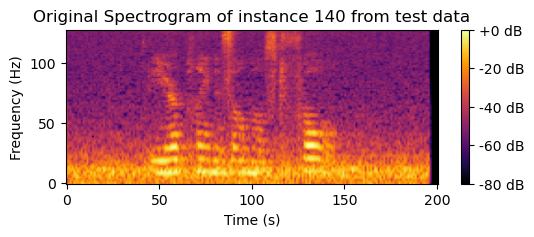

In [16]:
index = 140  # here to change
ima = ds_test.data[index][1]
label = ds_test.labels[index]

print("Label: ",ds_test.labels[index])
# Visualization
plt.figure(figsize=(6, 2))
#librosa.display.specshow(sample, sr=sr, hop_length=240, cmap='viridis', y_axis='hz')
plt.imshow(ima, aspect='auto', origin='lower', cmap='inferno')
plt.title(f"Original Spectrogram of instance {index} from test data")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format='%+2.0f dB')
plt.show()

### X-SER CRP

In [17]:
import sys
sys.path.append('../../')

In [18]:
from crp.crp.attribution import CondAttribution
from crp.crp.concepts import ChannelConcept
from crp.crp.helper import get_layer_names

from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm

from crp.crp.visualization import FeatureVisualization
from crp.crp.image import plot_grid, imgify

In [19]:
cc = ChannelConcept()

In [20]:
# mask channel 0 and 2 in batch 0
mask_fn = cc.mask(0, [0, 2])
print(mask_fn)

<function ChannelConcept.mask.<locals>.mask_fct at 0x7fd5c4d74720>


In [21]:
speech = ds_test.data[index][0]
Audio(speech)

In [22]:
instance1 = ds_test.data[index][1]
label = ds_test.labels[index]

print(instance1)
print(label,'maps to', LABELS[label])


[[-34.69411  -19.557655 -15.387772 ... -80.       -80.       -80.      ]
 [-35.285786 -22.102554 -16.47651  ... -80.       -80.       -80.      ]
 [-38.814926 -27.078316 -17.248314 ... -80.       -80.       -80.      ]
 ...
 [-51.961666 -52.87876  -51.43488  ... -80.       -80.       -80.      ]
 [-51.423794 -52.582447 -51.491356 ... -80.       -80.       -80.      ]
 [-51.584755 -51.820976 -54.726425 ... -80.       -80.       -80.      ]]
6 maps to sad


In [23]:
from zennit.torchvision import ResNetCanonizer
canonizers = [ResNetCanonizer()]
composite = EpsilonPlusFlat(canonizers)

In [24]:
# describes how the attributions should be computed on the dataset
attribution = CondAttribution(model, no_param_grad=True)

In [25]:
from crp.crp.helper import get_layer_names
# compute heatmap wrt. output 0 
'''0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'''

selected_value = 'disgust'
conditions = [{"y": label}]

sample = torch.tensor(instance1, dtype=torch.float32, requires_grad=True).unsqueeze(0).unsqueeze(0).to(device) #  add batch and channel dimensions

attr = attribution(sample, conditions, composite, mask_map=cc.mask)

/home/seham/miniconda3/envs/audio/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [26]:
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_names

['conv1',
 'layer1.conv1',
 'layer1.conv2',
 'layer1.shortcut',
 'layer2.conv1',
 'layer2.conv2',
 'layer2.shortcut',
 'fc']

In [27]:
layer = model.layer1.conv1
print(f"Weight shape:{layer.weight.shape}")
# Print the number of input and output channels
print(f"Input channels: {layer.in_channels}")
print(f"Output channels: {layer.out_channels}")

Weight shape:torch.Size([64, 32, 3, 3])
Input channels: 32
Output channels: 64


### Select Concepts ID (the most relevant to the prediction)


In [28]:
from crp.crp.helper import get_layer_names

# the six most relevant concepts and their contribution to final classification in percent
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

conditions = [{'y': label}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)

attr.activations['layer2.conv2'].shape, attr.relevances['layer2.conv2'].shape

rel_c = cc.attribute(attr.relevances['layer2.conv2'], abs_norm=True)


rel_values, concept_ids = torch.topk(rel_c[0], 6)
print(rel_values)
print("Most relevant concepts: ",concept_ids)

tensor([0.0197, 0.0099, 0.0093, 0.0062, 0.0053, 0.0049], device='cuda:0')
Most relevant concepts:  tensor([119,  77,  71,  33,  55, 125], device='cuda:0')


True


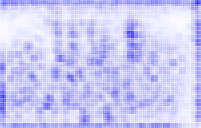

In [29]:
conditions = [{"y": label}]

# zennit requires gradients
#sample.requires_grad = True
attr = attribution(sample, conditions, composite, mask_map=cc.mask)

# or use a dictionary for mask_map
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
mask_map = {name: cc.mask for name in layer_names}

attr = attribution(sample, conditions, composite, mask_map=mask_map)
heatmap= attr.heatmap

print(torch.equal(attr[0], attr.heatmap))

imgify(attr.heatmap, symmetric=True)

hello from mask
hello from mask_fct, 
  tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],

         [[-1.7531e+00, -4.2236e+00, -5.3859e+00,  ..., -4.4924e+00,
           -3.6570e+00, -2.2139e+00],
          [-2.4958e+00, -6.7340e+00, -7.8785e+00,  ..., -7.1499e+00,
           -6.2140e+00, -4.3681e+00],
          [-1.1281e+00, -3.9797e+00, -4.2467e+00,  ..., -3.6731e+00,
           -2.3818

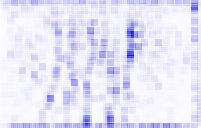

In [30]:
# First Layer 
# Most relevant concepts:  tensor([33, 10, 42, 55, 56, 57]
conditions = [{"y": [label], "layer1.conv1": [35]}]
heatmap1, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap1, symmetric=True)

hello from mask
wrt. class 3
hello from mask_fct, 
  tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[2.4941e+00, 6.1918e+00, 8.3564e+00,  ..., 7.1793e+00,
           5.6924e+00, 3.4756e+00],
          [3.4454e+00, 9.5435e+00, 1.1819e+01,  ..., 1.1161e+01,
           9.3735e+00, 6.6761e+00],
          [1.4878e+00, 5.4437e+00, 6.0703e+00,  ..., 5.6035e+00,
           3.5044e+00, 3.4535e+00],
          ...,
      

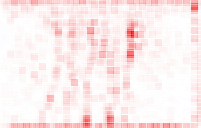

In [31]:
''' 
    we want to initialize the relevance at the logit position of 
    the highest confidence, then we could define the following function and omit the "y" parameter
'''
softmax = torch.nn.Softmax(dim=-1)
def select_max(pred):
    id = softmax(pred).argmax(-1).item()
    print(f"wrt. class {id}")
    mask = torch.zeros_like(pred)
    mask[0, id] = pred[0, id]
    return mask

conditions = [{"layer1.conv1": [35]}] # 35
heatmap2, _, _, _ = attribution(sample, conditions, composite, init_rel=select_max)
imgify(heatmap2, symmetric=True)

hello from mask
hello from mask_fct, 
  tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.1368, -0.1368, -0.1368,  ...,  0.0000,  0.0000,  0.0000],
          [-0.1368, -0.1368, -0.1368,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0440,  0.0440,  0.0440,  ...,  0.0440,  0.0440, 

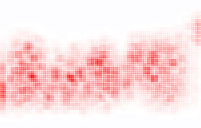

In [32]:
# Last layer concepts are 119, 103,  77,  71,  55,  84

conditions = [{"y": [label], "layer2.conv2": [103]}]
heatmap3, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap3, symmetric=True)

### _____________________________________________________

In [33]:
from heatmap_proc import sliding_win, overlay_top_windows, get_log_melspe

top_k_indices, top_windows,ts = sliding_win(heatmap3, 10, 5)
print(top_k_indices, ts, len(top_windows))

[2, 10, 3, 15, 9] [(20, 30), (100, 110), (30, 40), (150, 160), (90, 100)] 5


In [34]:
index

140

Top Window Indices: [13, 8, 10, 12, 11] 
Time steps: [(130, 140), (80, 90), (100, 110), (120, 130), (110, 120)] 
Length of windows: 5
time steps for projection:   [(1.95, 2.1), (1.2, 1.3499999999999999), (1.5, 1.65), (1.7999999999999998, 1.95), (1.65, 1.7999999999999998)]

 time steps length is:  0.15000000000000013


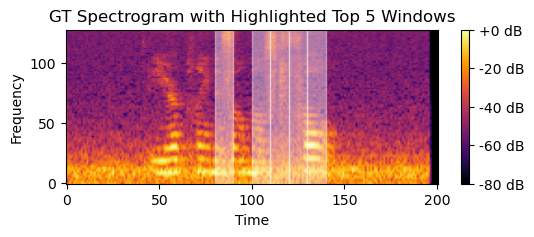

In [35]:

import soundfile as sf

heatmap_tensor = heatmap2
#heatmap_tensor = attr.heatmap
win_wid = 10 #13
k= 5  #select top 5 window width
#_____________
# Input audio file
audio_path = ds_test.data[index][0] # Load the audio file path
sample_rate = 24000
#_____________
# Load the spectrogram
# Shape (1, 128, time)
audio, sr = librosa.load(audio_path, sr= 24000)
spec_tensor = torch.tensor(get_log_melspe(audio, sr)).unsqueeze(0) 
#_________________

top_indices, top_windows, ts = sliding_win(heatmap_tensor, win_wid, k) # heatmap_tensor
print("Top Window Indices:", top_indices, "\nTime steps:", ts, "\nLength of windows:", len(top_windows) )
time_steps = [(start*0.015, end * 0.015) for start, end in ts]
print("time steps for projection:  ", time_steps)
print("\n time steps length is: ",((ts[0][1]*0.015) - (ts[0][0]*0.015)))

# Visualization
plt.figure(figsize=(6, 2))
#librosa.display.specshow(sample, sr=sr, hop_length=240, cmap='viridis', y_axis='hz')
plt.imshow(instance1, aspect='auto', origin='lower', cmap='inferno')
plt.title(f"GT Spectrogram with Highlighted Top {k} Windows")
plt.xlabel("Time")
plt.ylabel("Frequency")
for start,end in ts:
    plt.axvspan(start, end, color='white', alpha=0.4) 
plt.colorbar(format='%+2.0f dB')
plt.show()

Audio(ds_test.data[index][0])

In [36]:
audio_path = ds_test.data[index][0]

In [37]:

y, sr = librosa.load(audio_path, sr=24000)

# Trim silence at the beginning and end (librosa's default threshold)
y_trimmed, index = librosa.effects.trim(y, top_db=9)  # Adjust `top_db` for sensitivity

# Save the trimmed audio
trimmed_audio_path = "trimmed_audio32.wav"
sf.write(trimmed_audio_path, y_trimmed, sr)

print(f"Trimmed audio saved to: {trimmed_audio_path}")

Trimmed audio saved to: trimmed_audio32.wav


### Features Analysis



#### Groundtruth file analysis

In [38]:
import librosa
import numpy as np

# Load audio file
#audio_path = ds_test.data[index][0]
audio_path = "trimmed_audio32.wav"
y, sr = librosa.load(audio_path, sr=24000)
print(sr)

# Window parameters
window_size = int(sr * 0.15)  # 0.5 second window
hop_length = int(sr * 0.27)  # 0.25 second hop length is 50% of win width
overlap_length = window_size - hop_length  # Calculate overlap length
print(f"Window Size: {window_size}, Hop Length: {hop_length}, Overlap Length: {overlap_length}")

# Calculate loudness (RMS)
loudness = librosa.feature.rms(y=y, frame_length=window_size, hop_length=hop_length).flatten()

# Calculate shrillness (Spectral Centroid)
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length).flatten()


# Convert indices to time intervals
def time_step(idx, hop_length, sr):
    start = (idx * hop_length) / sr
    end = ((idx * hop_length) + window_size) / sr
    return (start, end)
'''
# the top-k values that are below the overall mean of values
def top_k_intervals(values, k=5):
    #top_k_indices = np.argsort(values)[-k:][::-1]  # Indices of top-k values in descending order
    values = np.asarray(values)
    mean_value = np.mean(values)
    # Select values below the mean
    below_avg_indices = np.where(values < mean_value)[0]
    below_avg_values = values[below_avg_indices]
    top_k_indices = below_avg_indices[np.argsort(below_avg_values)[-k:][::-1]]
    #top_k_indices = np.argsort(values)[:k]  # Indices of bottom-k values in ascending order
    return [time_step(idx, hop_length, sr) for idx in top_k_indices]
'''
def bottom_k_intervals(values, k):
    values = np.asarray(values)
    bottom_k_indices = np.argsort(values)[:k]  # Indices of bottom-k values in ascending order
    return [time_step(idx, hop_length, sr) for idx in bottom_k_indices]
# Top 5 time intervals
#top_loudness_intervals = top_k_intervals(loudness, k=5)
#top_shrillness_intervals = top_k_intervals(spectral_centroid, k=5)
lowest_loudness = bottom_k_intervals(loudness, k = 5)
lowest_shrillness = bottom_k_intervals(spectral_centroid, k =5)

# Print results
print("Time steps:                      ", time_steps)
#print("Top 5 Time Intervals of Loudness below the avg:", top_loudness_intervals)
#print("Top 5 Time Intervals of Shrillness below th avg:", top_shrillness_intervals)
print("lowest_loudness:  ", lowest_loudness)
print("lowest shrillness: ", lowest_shrillness)


24000
Window Size: 3600, Hop Length: 6480, Overlap Length: -2880
Time steps:                       [(1.95, 2.1), (1.2, 1.3499999999999999), (1.5, 1.65), (1.7999999999999998, 1.95), (1.65, 1.7999999999999998)]
lowest_loudness:   [(0.0, 0.15), (0.27, 0.42), (2.16, 2.31), (2.43, 2.58), (1.89, 2.04)]
lowest shrillness:  [(1.62, 1.77), (1.08, 1.23), (1.89, 2.04), (0.54, 0.69), (2.43, 2.58)]


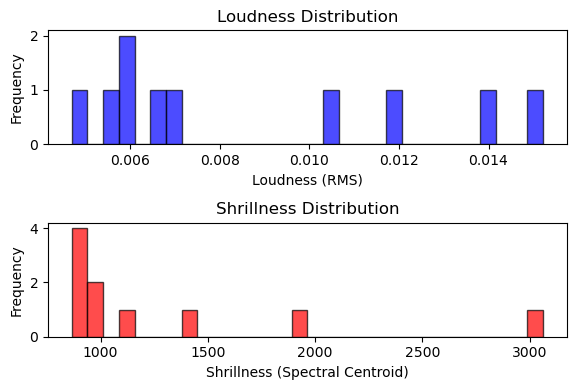

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import ace_tools as tools

# Compute time steps
times = librosa.times_like(loudness, sr=sr, hop_length=hop_length)

# Save time steps, loudness, and shrillness as a DataFrame
df_features = pd.DataFrame({
    "Time (s)": times,
    "Loudness (RMS)": loudness,
    "Shrillness (Spectral Centroid)": spectral_centroid
})

# Display DataFrame for user
#tools.display_dataframe_to_user(name="Speech Features Data", dataframe=df_features)

# Plot histograms
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=False)

# Loudness (RMS) Histogram
ax[0].hist(loudness, bins=30, color='b', alpha=0.7, edgecolor='black')
ax[0].set_xlabel('Loudness (RMS)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Loudness Distribution')

# Shrillness (Spectral Centroid) Histogram
ax[1].hist(spectral_centroid, bins=30, color='r', alpha=0.7, edgecolor='black')
ax[1].set_xlabel('Shrillness (Spectral Centroid)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Shrillness Distribution')

plt.tight_layout()
plt.show()


In [44]:
# Calculate the total number of intervals for each feature
total_loudness_intervals = len(loudness)
total_shrillness_intervals = len(spectral_centroid)

# Print the total number of intervals
print("Total Intervals for Loudness:", total_loudness_intervals)
print("Total Intervals for Shrillness:", total_shrillness_intervals)

Total Intervals for Loudness: 10
Total Intervals for Shrillness: 10


### Score Calculation

In [45]:
def explanation_analysis(B_start,B_end, A_start,A_end):
        interval =[(A_start,A_end)]
        #print(interval)
        Scores = []
        overlap_start = max(B_start,A_start)
        overlap_end = min(B_end,A_end)
        if overlap_start < overlap_end:
            Time_duration = (overlap_end - overlap_start)
            # print("Time duration: ",Time_duration)
            B_duration = B_end - B_start
            # print("B_duration:", B_duration)
            Score = (Time_duration/B_duration)*100
            print("The Aligned time interval is: ", [B_start, B_end])
            # print("Socre:", Score)

        else:
            Score = 0.0

        if Score != 0:
             Scores.append(Score)

        return Scores

print("_____________________Loudness__________________________")
Loudness_Scores = []
for B_start, B_end in time_steps:
    for A_start,A_end in lowest_loudness:
        #print(B_start, B_end, A_start,A_end)
        score = explanation_analysis(B_start, B_end, A_start,A_end)
        Loudness_Scores.append(score)
data = [item for sublist in Loudness_Scores if sublist for item in sublist]

print("Score: ",data)
print(f"Final Explanation Score of Loudness is: " ,sum(data)/len(data))
print(f"Final Explanation Score coverage rate of Loudness is: " ,sum(data)/k)
print(f"How many intervals that exp windows belongs to in the GT windows: {len(data)}\n")

print("_____________________Shrillness__________________________")

shrillness_Scores = []
for B_start, B_end in time_steps:
    for A_start,A_end in lowest_shrillness:
        #print(B_start, B_end, A_start,A_end)
        score = explanation_analysis(B_start, B_end, A_start,A_end)
        shrillness_Scores.append(score)
data2 = [item for sublist in shrillness_Scores if sublist for item in sublist]


print("Score: ",data2)
print(f"Final Explanation Score of Shrillness is: " ,sum(data2)/len(data2))
print(f"Final Explanation Score coverage rate of Shrillness is: " ,sum(data2)/k)
print(f"How many intervals that exp windows belongs to in the GT windows: {len(data2)}\n")


_____________________Loudness__________________________
The Aligned time interval is:  [1.95, 2.1]
The Aligned time interval is:  [1.7999999999999998, 1.95]
Score:  [60.0, 40.0]
Final Explanation Score of Loudness is:  50.0
Final Explanation Score coverage rate of Loudness is:  20.0
How many intervals that exp windows belongs to in the GT windows: 2

_____________________Shrillness__________________________
The Aligned time interval is:  [1.95, 2.1]
The Aligned time interval is:  [1.2, 1.3499999999999999]
The Aligned time interval is:  [1.5, 1.65]
The Aligned time interval is:  [1.7999999999999998, 1.95]
The Aligned time interval is:  [1.65, 1.7999999999999998]
Score:  [60.0, 20.00000000000003, 19.999999999999883, 40.0, 80.00000000000011]
Final Explanation Score of Shrillness is:  44.00000000000001
Final Explanation Score coverage rate of Shrillness is:  44.00000000000001
How many intervals that exp windows belongs to in the GT windows: 5



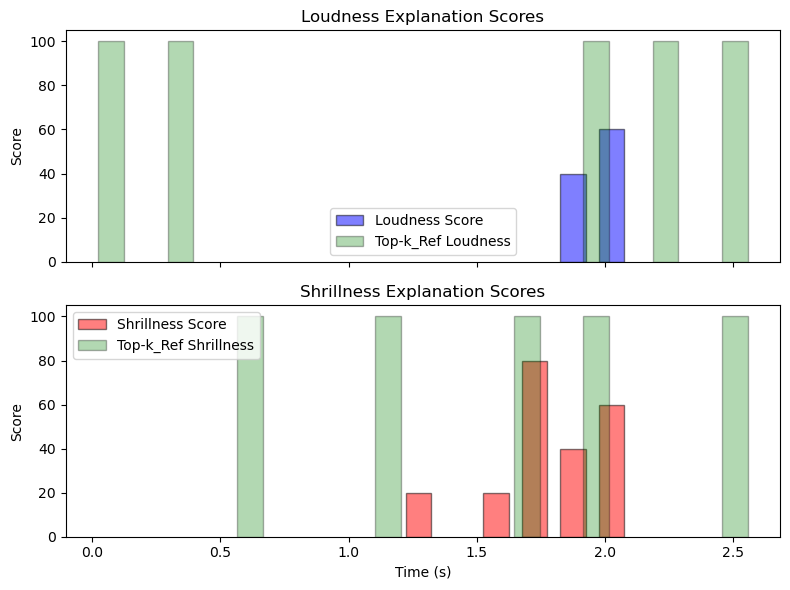

In [49]:
import matplotlib.pyplot as plt

# Data for lowest Loudness and Shrillness intervals (100% score each)
lowest_loudness_intervals = [(0.0, 0.15), (0.27, 0.42), (2.16, 2.31), (2.43, 2.58), (1.89, 2.04)]
lowest_shrillness_intervals = [(1.62, 1.77), (1.08, 1.23), (1.89, 2.04), (0.54, 0.69), (2.43, 2.58)]

# Data for Loudness Explanation Scores
loudness_intervals = [(1.95, 2.1), (1.8, 1.95)]
loudness_scores = [60.0, 40.0]

# Data for Shrillness Explanation Scores
shrillness_intervals = [(1.95, 2.1), (1.2, 1.345), (1.5, 1.65), (1.8, 1.95), (1.65, 1.8)]
shrillness_scores = [60.0, 20.0, 20.0, 40.0, 80.0]

# Convert intervals to midpoints for plotting
loudness_midpoints = [(start + end) / 2 for start, end in loudness_intervals]
shrillness_midpoints = [(start + end) / 2 for start, end in shrillness_intervals]

lowest_loudness_midpoints = [(start + end) / 2 for start, end in lowest_loudness_intervals]
lowest_shrillness_midpoints = [(start + end) / 2 for start, end in lowest_shrillness_intervals]

# Assign a uniform score (100%) for lowest values
lowest_loudness_scores = [100] * len(lowest_loudness_midpoints)
lowest_shrillness_scores = [100] * len(lowest_shrillness_midpoints)

# Plot histograms
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Loudness Histogram
ax[0].bar(loudness_midpoints, loudness_scores, width=0.1, color='b', alpha=0.5, edgecolor='black', label="Loudness Score")
ax[0].bar(lowest_loudness_midpoints, lowest_loudness_scores, width=0.1, color='green', alpha=0.3, edgecolor='black', label="Top-k_Ref Loudness")  # Transparent green
ax[0].set_ylabel('Score')
ax[0].set_title('Loudness Explanation Scores')
ax[0].legend()

# Shrillness Histogram
ax[1].bar(shrillness_midpoints, shrillness_scores, width=0.1, color='r', alpha=0.5, edgecolor='black', label="Shrillness Score")
ax[1].bar(lowest_shrillness_midpoints, lowest_shrillness_scores, width=0.1, color='green', alpha=0.3, edgecolor='black', label="Top-k_Ref Shrillness")  # Transparent green
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Score')
ax[1].set_title('Shrillness Explanation Scores')
ax[1].legend()

plt.tight_layout()
plt.show()


Playing window: 1.95s to 2.1s
[0.00940878]


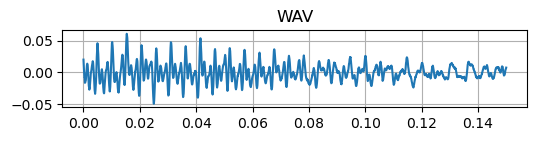

Playing window: 1.2s to 1.3499999999999999s
[0.01651796]


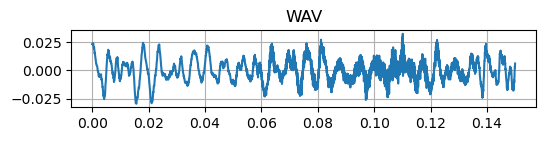

Playing window: 1.5s to 1.65s
[0.01149496]


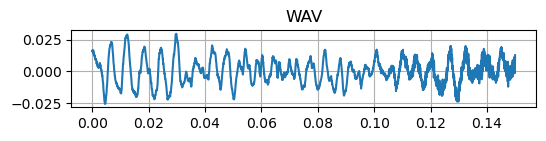

Playing window: 1.7999999999999998s to 1.95s
[0.00280988]


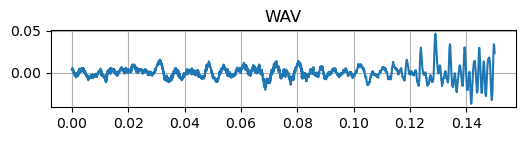

Playing window: 1.65s to 1.7999999999999998s
[0.00435597]


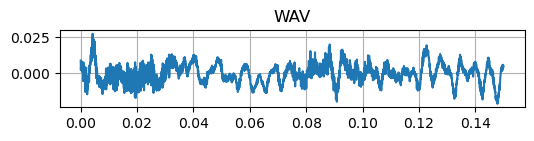

In [ ]:
from IPython.display import Audio

extracted_windows = []
for start, end in time_steps:
    start_sample = int(start * sr)
    end_sample = int(end*sr)
    window = audio[start_sample:end_sample]
    extracted_windows.append(audio[start_sample:end_sample])
    print(f"Playing window: {start}s to {end}s")

    loudness = librosa.feature.rms(y=window, frame_length=win_wid, hop_length=hop_length).flatten()
    print(loudness)
    # Display the audio
    
    time = np.linspace(0, len(window)/sr, num= len(window))

    plt.figure(figsize=(6,1))
    plt.plot(time,window)
    plt.title("WAV")
    plt.grid()
    plt.show()
    display(Audio(window, rate=sr))


#### Extract Features of the important clip

In [ ]:
from heatmap_proc import trim_audio
data, sr = librosa.load(ds_test.data[index][0], sr=24000)
audio = trim_audio(data, sr)

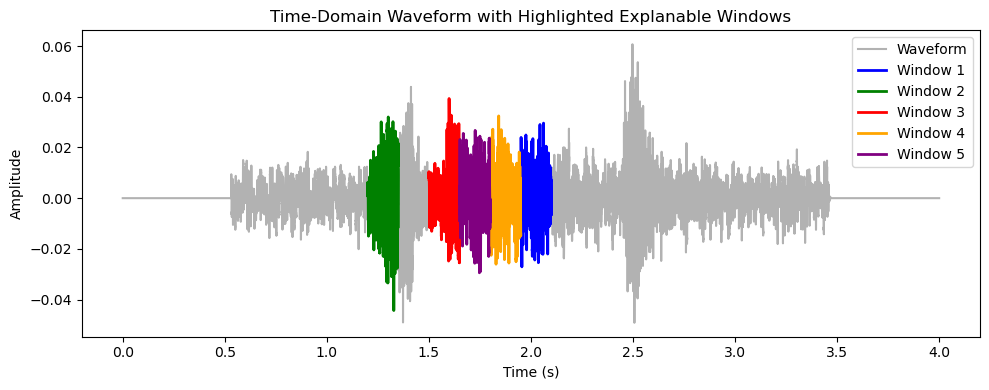

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `audio`, `sr`, and `time_steps` are already defined
plt.figure(figsize=(10, 4))
time = np.linspace(0, len(audio) / sr, len(audio))

# Plot the full waveform in gray
plt.plot(time, audio, label="Waveform", color="gray", alpha=0.6)

# Define colors for different windows
colors = ["blue", "green", "red", "orange", "purple"]  # Extend this list as needed

# Overlay selected windows in different colors
for i, (start, end) in enumerate(time_steps):
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    plt.plot(
        time[start_sample:end_sample],
        audio[start_sample:end_sample],
        color=colors[i % len(colors)],
        label=f"Window {i + 1}",
        linewidth=2,  # Thicker line for better visibility
    )

# Add labels, legend, and display
plt.title("Time-Domain Waveform with Highlighted Explanable Windows")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
Audio(ds_test.data[index][0])

In [ ]:
'''
for start, end in time_steps:
    start_sample = int(start * sr)
    end_sample = int(end*sr)
    # Plot the waveform
    plt.figure(figsize=(6, 2))
    time = np.linspace(0, len(audio) / sr, len(audio))

    # Plot the full waveform
    plt.plot(time, audio, label="Waveform", color="gray", alpha=0.6)

    # Highlight the selected section
    plt.plot(time[start_sample:end_sample], audio[start_sample:end_sample], color="blue", label="Selected Window")

    # Add labels and legend
    plt.title("Time-Domain Waveform with Highlighted Window")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Extract the selected portion
    selected_audio = audio[start_sample:end_sample]'''

'\nfor start, end in time_steps:\n    start_sample = int(start * sr)\n    end_sample = int(end*sr)\n    # Plot the waveform\n    plt.figure(figsize=(6, 2))\n    time = np.linspace(0, len(audio) / sr, len(audio))\n\n    # Plot the full waveform\n    plt.plot(time, audio, label="Waveform", color="gray", alpha=0.6)\n\n    # Highlight the selected section\n    plt.plot(time[start_sample:end_sample], audio[start_sample:end_sample], color="blue", label="Selected Window")\n\n    # Add labels and legend\n    plt.title("Time-Domain Waveform with Highlighted Window")\n    plt.xlabel("Time (s)")\n    plt.ylabel("Amplitude")\n    plt.legend()\n    plt.tight_layout()\n    plt.show()\n    # Extract the selected portion\n    selected_audio = audio[start_sample:end_sample]'

In [ ]:
print(f"Top windows:{extracted_windows},\n Number of windows = {len(extracted_windows)}")

Top windows:[array([0.02014736, 0.01547096, 0.01182944, ..., 0.00589631, 0.00689653,
       0.00759918], dtype=float32), array([0.02337223, 0.02378223, 0.02325442, ..., 0.00355497, 0.00280755,
       0.0061475 ], dtype=float32), array([ 0.01596622,  0.01651705,  0.0160667 , ..., -0.00134302,
        0.00550145,  0.01276925], dtype=float32), array([0.00413755, 0.00446008, 0.00410357, ..., 0.02926555, 0.02570627,
       0.02323864], dtype=float32), array([0.00896198, 0.00226725, 0.00342301, ..., 0.00541988, 0.00545014,
       0.00475326], dtype=float32)],
 Number of windows = 5


hello from mask
hello from mask_fct, 
  tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.1368, -0.1368, -0.1368,  ...,  0.0000,  0.0000,  0.0000],
          [-0.1368, -0.1368, -0.1368,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0440,  0.0440,  0.0440,  ...,  0.0440,  0.0440, 

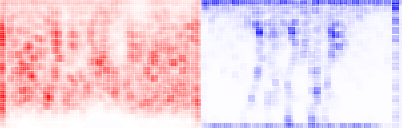

In [ ]:
# layer1.conv1 concepts id: ([33, 10, 42, 55, 56, 57]
# layer2.conv2 concepts id: [119,  77,  71,  33,  55, 125]
# layer1.conv2 concepts id: [15, 12, 39, 49, 23, 38]

conditions = [{"layer2.conv2": [77], "y": [6]}, {"layer1.conv1": [55], "y": [6]}]
heatmaps, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmaps, symmetric=True, grid=(1, len(heatmaps)))

Initializing Relevance

hello from mask
hello from mask_fct, 
  tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],

         [[-1.5883e-02, -3.8268e-02, -4.8802e-02,  ..., -4.0701e-02,
           -3.3133e-02, -2.0058e-02],
          [-2.2612e-02, -6.1011e-02, -7.1384e-02,  ..., -6.4776e-02,
           -5.6299e-02, -3.9576e-02],
          [-1.0220e-02, -3.6057e-02, -3.8477e-02,  ..., -3.3278e-02,
           -2.1579

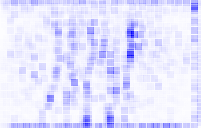

In [ ]:
conditions = [{"y": [label], "layer1.conv1": [35]}]
heatmap, _, _, _ = attribution(sample, conditions, composite, init_rel=-1)

imgify(heatmap, symmetric=True)

hello from mask
wrt. class 3
hello from mask_fct, 
  tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[2.4941e+00, 6.1918e+00, 8.3564e+00,  ..., 7.1793e+00,
           5.6924e+00, 3.4756e+00],
          [3.4454e+00, 9.5435e+00, 1.1819e+01,  ..., 1.1161e+01,
           9.3735e+00, 6.6761e+00],
          [1.4878e+00, 5.4437e+00, 6.0703e+00,  ..., 5.6035e+00,
           3.5044e+00, 3.4535e+00],
          ...,
      

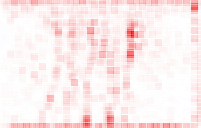

In [ ]:
softmax = torch.nn.Softmax(dim=-1)
def select_max(pred):
    id = softmax(pred).argmax(-1).item()
    print(f"wrt. class {id}")
    mask = torch.zeros_like(pred)
    mask[0, id] = pred[0, id]
    return mask

conditions = [{"layer1.conv1": [35]}]
heatmap, _, _, _ = attribution(sample, conditions, composite, init_rel=select_max)
imgify(heatmap, symmetric=True)

hello from mask
hello from mask_fct, 
  tensor([[[[-6.7409e-01, -6.6690e-01, -6.4636e-01,  ..., -9.1742e-01,
           -1.9380e+00, -6.9988e-01],
          [-7.1869e-01, -5.6251e-01, -4.2851e-01,  ..., -9.5571e-01,
           -3.8021e+00, -3.1935e+00],
          [-8.2265e-01, -6.8979e-01, -4.8950e-01,  ..., -9.6607e-01,
           -3.1400e+00, -2.7211e+00],
          ...,
          [-1.4809e+00, -1.4466e+00, -8.3583e-01,  ..., -1.4408e+00,
           -2.8541e+00, -2.3783e+00],
          [-1.7838e+00, -1.5456e+00, -1.0887e+00,  ..., -1.8454e+00,
           -3.0902e+00, -1.8355e+00],
          [-1.1081e+00, -9.6480e-01, -7.1922e-01,  ..., -1.2349e+00,
           -2.1463e+00, -1.7640e+00]],

         [[ 1.7873e+00,  2.8263e+00,  2.9366e+00,  ...,  4.2091e+00,
            3.7039e+00,  2.9980e+00],
          [ 2.3497e+00,  3.4695e+00,  3.4387e+00,  ...,  5.1206e+00,
            4.6465e+00,  4.1710e+00],
          [ 1.7804e+00,  2.8053e+00,  2.6175e+00,  ...,  3.7707e+00,
            2.6273

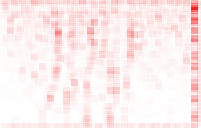

In [ ]:
conditions = [{"layer1.conv1": [35]}]

heatmap, _, _, _ = attribution(sample, conditions, composite, start_layer="layer1.conv1")

imgify(heatmap, symmetric=True)

Recording and Attributing Latent Concept Relevances

In [ ]:
from crp.crp.helper import get_layer_names

# the six most relevant concepts and their contribution to final classification in percent
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

conditions = [{'y': label}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)

attr.activations['layer1.conv2'].shape, attr.relevances['layer1.conv2'].shape

rel_c = cc.attribute(attr.relevances['layer1.conv2'], abs_norm=True)


rel_values, concept_ids = torch.topk(rel_c[0], 6)
print(rel_values)
print("Most relevant concepts: ",concept_ids)


tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')
Most relevant concepts:  tensor([15, 12, 39, 49, 23, 38], device='cuda:0')


In [ ]:
rel_c = cc.attribute(attr.relevances['layer2.conv2'], abs_norm=True)
rel_c.shape

torch.Size([1, 128])

In [ ]:
# the six most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 6)
print(rel_values)
print("Most relevant concepts: ",concept_ids)
concept_ids, rel_values*100

tensor([0.0197, 0.0099, 0.0093, 0.0062, 0.0053, 0.0049], device='cuda:0')
Most relevant concepts:  tensor([119,  77,  71,  33,  55, 125], device='cuda:0')


(tensor([119,  77,  71,  33,  55, 125], device='cuda:0'),
 tensor([1.9714, 0.9856, 0.9267, 0.6179, 0.5306, 0.4933], device='cuda:0'))

hello from mask
hello from mask
hello from mask
hello from mask
hello from mask
hello from mask
hello from mask_fct, 
  tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.1368, -0.1368, -0.1368,  ...,  0.0000,  0.0000,  0.0000],
          [-0.1368, -0.1368, -0.1368,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.

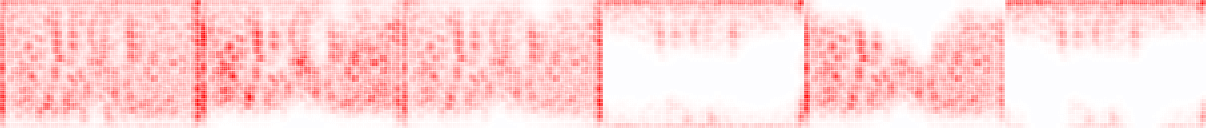

In [ ]:
conditions = [{'layer2.conv2': [id], 'y': label} for id in concept_ids]

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(concept_ids)))

Conditions with Several Layers

In [ ]:
conditions = [{"layer2.conv2": [35], "layer1.conv2": [24], "y": label}]

### BBModel inference

In [ ]:
indices = np.where(y_test == 6)[0]

print(indices)

[  0   2  18  24  25  46  48  49  65  69  72  76  77  79  98 101 102 106
 107 116 118 126 130 134 140 156 160 161 162 169 173 179 188 192 196 199
 205 207 210 212 215 217 218 219 221 224 228 235 236 254 262 277 284 285
 286 295 303 315 319 336 338 348 349 355 368 369 375 393 398 400 411 418
 425 428 433 438 440 453 459 461 476 479 496 498 503 507 517 519 527 532
 537 547 548 549 553 556 560 564 567 578 579 580 594 596 614 622 623 625
 643 660 669 678 691 697 702 705 708 709 724 740 742]


In [ ]:
predicted = []
for index2 in indices:    
    instance2 = ds_test.data[index2][1]
    label2 = ds_test.labels[index2]

    #print(instance2)
    print(label2,'maps to', LABELS[label2])
    sample2 = torch.tensor(instance2, dtype=torch.float32, requires_grad=True).unsqueeze(0).unsqueeze(0).to(device) #  add batch and channel dimensions
    with torch.no_grad():
        output = model(sample2)
        predicted_class = torch.argmax(output, dim=1).item()

    #LABEL_DICT = {0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'}
    Emotion = LABEL_DICT[label2]
    predicted.append(predicted_class)
    # Print the results
    print(f"True Label: {label2} which is {Emotion}")
    print(f"Predicted Class: {predicted_class}")

print(predicted)

6 maps to sad
True Label: 6 which is sad
Predicted Class: 6
6 maps to sad
True Label: 6 which is sad
Predicted Class: 6
6 maps to sad
True Label: 6 which is sad
Predicted Class: 0
6 maps to sad
True Label: 6 which is sad
Predicted Class: 2
6 maps to sad
True Label: 6 which is sad
Predicted Class: 1
6 maps to sad
True Label: 6 which is sad
Predicted Class: 2
6 maps to sad
True Label: 6 which is sad
Predicted Class: 1
6 maps to sad
True Label: 6 which is sad
Predicted Class: 0
6 maps to sad
True Label: 6 which is sad
Predicted Class: 1
6 maps to sad
True Label: 6 which is sad
Predicted Class: 6
6 maps to sad
True Label: 6 which is sad
Predicted Class: 6
6 maps to sad
True Label: 6 which is sad
Predicted Class: 6
6 maps to sad
True Label: 6 which is sad
Predicted Class: 0
6 maps to sad
True Label: 6 which is sad
Predicted Class: 0
6 maps to sad
True Label: 6 which is sad
Predicted Class: 4
6 maps to sad
True Label: 6 which is sad
Predicted Class: 6
6 maps to sad
True Label: 6 which is sad

In [ ]:
with torch.no_grad():
    output = model(sample2)
    predicted_class = torch.argmax(output, dim=1).item()

#LABEL_DICT = {0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'}
Emotion = LABEL_DICT[label2]

# Print the results
print(f"True Label: {label2} which is {Emotion}")
print(f"Predicted Class: {predicted_class}")

True Label: 6 which is sad
Predicted Class: 6
